In [6]:
# Jupyter magic
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # standard Python plotting library

# import the read_block function from the tdt package
from tdt import read_block, download_demo_data, StructType

#%% Importing the Data
#download_demo_data()
BLOCKPATH = 'data/VTA4-190125-100559'
data = read_block(BLOCKPATH)

#%% my data:
BLOCKPATH= r'H:\TDT Photometry tanks\DP_DSTrainingv02-190822-171545\_VP-VTA-FP round 2\VP-VTA-FP8and9-191118-114543'
data = read_block(BLOCKPATH)
print(data)

Found Synapse note file: data/VTA4-190125-100559\Notes.txt
read from t=0s to t=785.44s
read from t=0s to t=3669.78s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])


In [7]:
#Jupyter has a bug that requires import of matplotlib outside of cell with matplotlib inline magic to properly apply rcParams

import matplotlib
matplotlib.rcParams['font.size'] = 18 # set font size for all figures

# Make some variables up here to so if they change in new recordings you won't have to change everything downstream
GCAMP = '_480G' # GCaMP channel
ISOS = '_405G' # Isosbestic channel
LICK = 'Ler_'

#My data 

ISOS = 'Dv2A' # 405nm channel. Formally STREAM_STORE1 in Matlab example
GCAMP = 'Dv1A' # 465nm channel. Formally STREAM_STORE2 in Matlab example
LICK= 'Lox1'

# Basic plotting and artifact removal

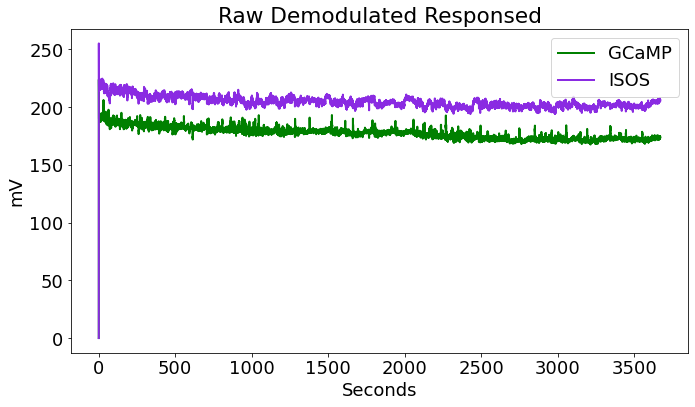

In [8]:
# Make a time array based on the number of samples and sample freq of 
# the demodulated streams
time = np.linspace(1,len(data.streams[GCAMP].data), len(data.streams[GCAMP].data))/data.streams[GCAMP].fs

# Plot both unprocessed demodulated stream            
fig1 = plt.figure(figsize=(10,6))
ax0 = fig1.add_subplot(111)

# Plotting the traces
p1, = ax0.plot(time, data.streams[GCAMP].data, linewidth=2, color='green', label='GCaMP')
p2, = ax0.plot(time, data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax0.set_ylabel('mV')
ax0.set_xlabel('Seconds')
ax0.set_title('Raw Demodulated Responsed')
ax0.legend(handles=[p1,p2], loc='upper right')
fig1.tight_layout()

# Jupyter for some reason (sometimes) shows the figure without be called, 
# Likely when plt.figure() is called
# otherwise you would call fig in a line by itself like:
# fig

# Artifact Removal

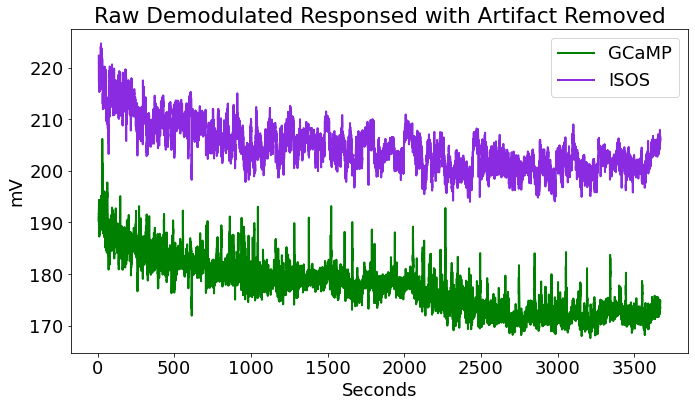

In [9]:
# There is often a large artifact on the onset of LEDs turning on
# Remove data below a set time t
t = 8
inds = np.where(time>t)
ind = inds[0][0]
time = time[ind:] # go from ind to final index
data.streams[GCAMP].data = data.streams[GCAMP].data[ind:]
data.streams[ISOS].data = data.streams[ISOS].data[ind:]

# Plot again at new time range
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces
p1, = ax1.plot(time,data.streams[GCAMP].data, linewidth=2, color='green', label='GCaMP')
p2, = ax1.plot(time,data.streams[ISOS].data, linewidth=2, color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Demodulated Responsed with Artifact Removed')
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()
# fig

# Downsample Data Doing Local Averaging

In [10]:
# Average around every Nth point and downsample Nx
N = 10 # Average every 10 samples into 1 value
F405 = []
F465 = []

for i in range(0, len(data.streams[GCAMP].data), N):
    F465.append(np.mean(data.streams[GCAMP].data[i:i+N-1])) # This is the moving window mean
data.streams[GCAMP].data = F465

for i in range(0, len(data.streams[ISOS].data), N):
    F405.append(np.mean(data.streams[ISOS].data[i:i+N-1]))
data.streams[ISOS].data = F405

#decimate time array to match length of demodulated stream
time = time[::N] # go from beginning to end of array in steps on N
time = time[:len(data.streams[GCAMP].data)]

# Detrending and dFF
# Full trace dFF according to Lerner et al. 2015
# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline

x = np.array(data.streams[ISOS].data)
y = np.array(data.streams[GCAMP].data)
bls = np.polyfit(x, y, 1)
Y_fit_all = np.multiply(bls[0], x) + bls[1]
Y_dF_all = y - Y_fit_all

dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
std_dFF = np.std(dFF)

C:\Users\Dakota\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


# Turn Licking Events into Lick Bouts

In [11]:
# First make a continous time series of Licking TTL events (epocs) and plot
LICK_on = data.epocs[LICK].onset
LICK_off = data.epocs[LICK].offset
# Add the first and last time stamps to make tails on the TTL stream
LICK_x = np.append(np.append(time[0], np.reshape(np.kron([LICK_on, LICK_off],
                   np.array([[1], [1]])).T, [1,-1])[0]), time[-1])
sz = len(LICK_on)
d = data.epocs[LICK].data
# Add zeros to beginning and end of 0,1 value array to match len of LICK_x
LICK_y = np.append(np.append(0,np.reshape(np.vstack([np.zeros(sz),
    d, d, np.zeros(sz)]).T, [1, -1])[0]),0)

y_scale = 10 #adjust according to data needs
y_shift = -20 #scale and shift are just for asthetics

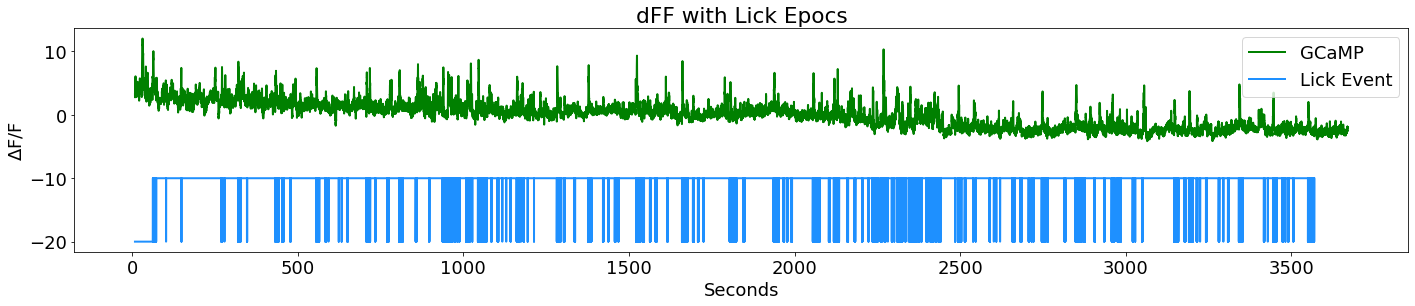

In [12]:
# First subplot in a series: dFF with lick epocs
fig3 = plt.figure(figsize=(20,12))
ax2 = fig3.add_subplot(311)

p1, = ax2.plot(time, dFF, linewidth=2, color='green', label='GCaMP')
p2, = ax2.plot(LICK_x, y_scale*LICK_y+y_shift, linewidth=2, color='dodgerblue', label='Lick Event')
ax2.set_ylabel(r'$\Delta$F/F')
ax2.set_xlabel('Seconds')
ax2.set_title('dFF with Lick Epocs')
ax2.legend(handles=[p1,p2], loc='upper right')
fig3.tight_layout()

# Lick Bout Logic
Now combine lick epocs that happen in close succession to make a single on/off event (a lick BOUT). Top view logic: if difference between consecutive lick onsets is below a certain time threshold and there was more than one lick in a row, then consider it as one bout, otherwise it is its own bout. Also, make sure a minimum number of licks was reached to call it a bout.

In [13]:
LICK_EVENT = 'LICK_EVENT'

LICK_DICT = {
        "name":LICK_EVENT,
        "onset":[],
        "offset":[],
        "type_str":data.epocs[LICK].type_str,
        "data":[]
        }
# pass StructType our new dictionary to make keys and values
data.epocs.LICK_EVENT = StructType(LICK_DICT)

lick_on_diff = np.diff(data.epocs[LICK].onset)
BOUT_TIME_THRESHOLD = 10
lick_diff_ind = np.where(lick_on_diff >= BOUT_TIME_THRESHOLD)[0]
#for some reason np.where returns a 2D array, hence the [0]

# Make an onset/ offset array based on threshold indicies
diff_ind = 0
for ind in lick_diff_ind: 
    # BOUT onset is thresholded onset index of lick epoc event
    data.epocs[LICK_EVENT].onset.append(data.epocs[LICK].onset[diff_ind])
    # BOUT offset is thresholded offset of lick event before next onset
    data.epocs[LICK_EVENT].offset.append(data.epocs[LICK].offset[ind])
    # set the values for data, arbitrary 1
    data.epocs[LICK_EVENT].data.append(1)
    diff_ind = ind + 1

# special case for last event to handle lick event offset indexing
data.epocs[LICK_EVENT].onset.append(data.epocs[LICK].onset[lick_diff_ind[-1]+1])
data.epocs[LICK_EVENT].offset.append(data.epocs[LICK].offset[-1])
data.epocs[LICK_EVENT].data.append(1)

# Now determine if it was a 'real' lick bout by thresholding by some
# user-set number of licks in a row
MIN_LICK_THRESH = 4 #four licks or more make a bout
licks_array = []

# Find number of licks in licks_array between onset and offset of 
# our new lick BOUT LICK_EVENT
for on, off in zip(data.epocs[LICK_EVENT].onset,data.epocs[LICK_EVENT].offset):
    licks_array.append(
        len(np.where((data.epocs[LICK].onset >= on) & (data.epocs[LICK].onset <= off))[0]))

# Remove onsets, offsets, and data of thrown out events
licks_array = np.array(licks_array)
inds = np.where(licks_array<MIN_LICK_THRESH)[0]
for index in sorted(inds, reverse=True):
    del data.epocs[LICK_EVENT].onset[index]
    del data.epocs[LICK_EVENT].offset[index]
    del data.epocs[LICK_EVENT].data[index]
    
# Make a continuous time series for lick BOUTS for plotting
LICK_EVENT_on = data.epocs[LICK_EVENT].onset
LICK_EVENT_off = data.epocs[LICK_EVENT].offset
LICK_EVENT_x = np.append(time[0], np.append(
    np.reshape(np.kron([LICK_EVENT_on, LICK_EVENT_off],np.array([[1], [1]])).T, [1,-1])[0], time[-1]))
sz = len(LICK_EVENT_on)
d = data.epocs[LICK_EVENT].data
LICK_EVENT_y = np.append(np.append(
    0, np.reshape(np.vstack([np.zeros(sz), d, d, np.zeros(sz)]).T, [1 ,-1])[0]), 0)

# Plot dFF with newly defined lick bouts

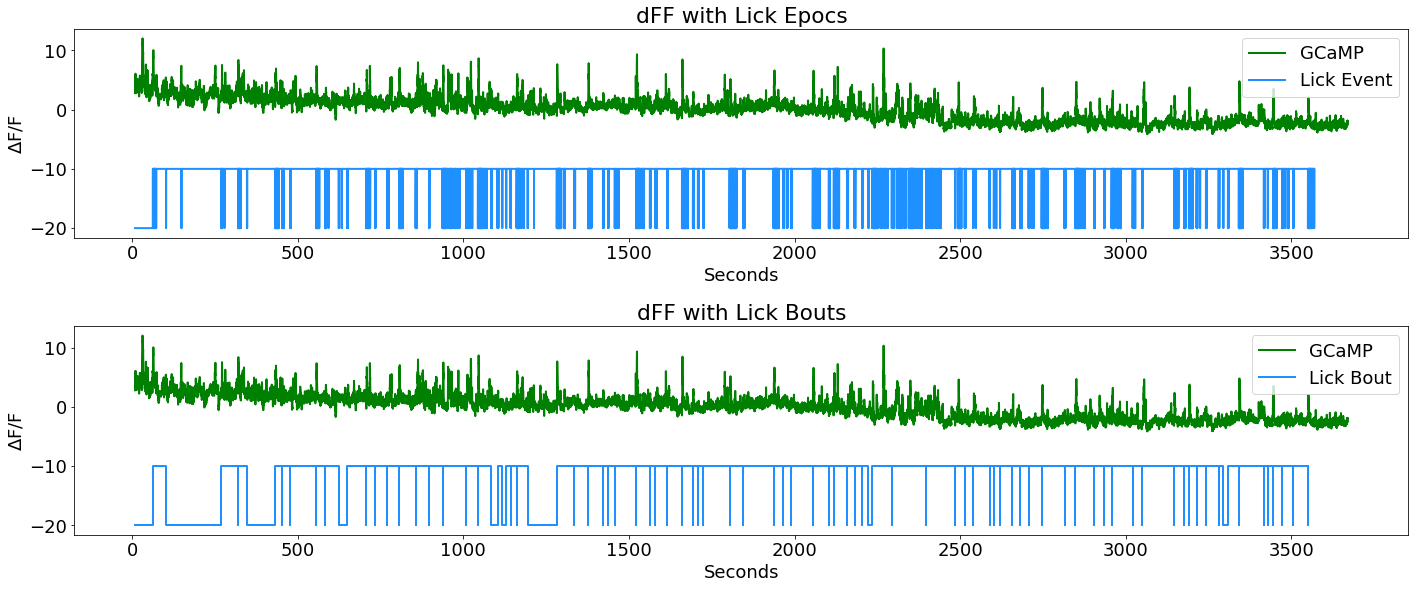

In [14]:
ax3 = fig3.add_subplot(312)
p1, = ax3.plot(time, dFF, linewidth=2, color='green', label='GCaMP')
p2, = ax3.plot(LICK_EVENT_x, y_scale*LICK_EVENT_y+y_shift, linewidth=2, color='dodgerblue', label='Lick Bout')
ax3.set_ylabel(r'$\Delta$F/F')
ax3.set_xlabel('Seconds')
ax3.set_title('dFF with Lick Bouts')
ax3.legend(handles=[p1, p2], loc='upper right')
fig3.tight_layout()
fig3

# Make nice area fills instead of epocs for asthetics

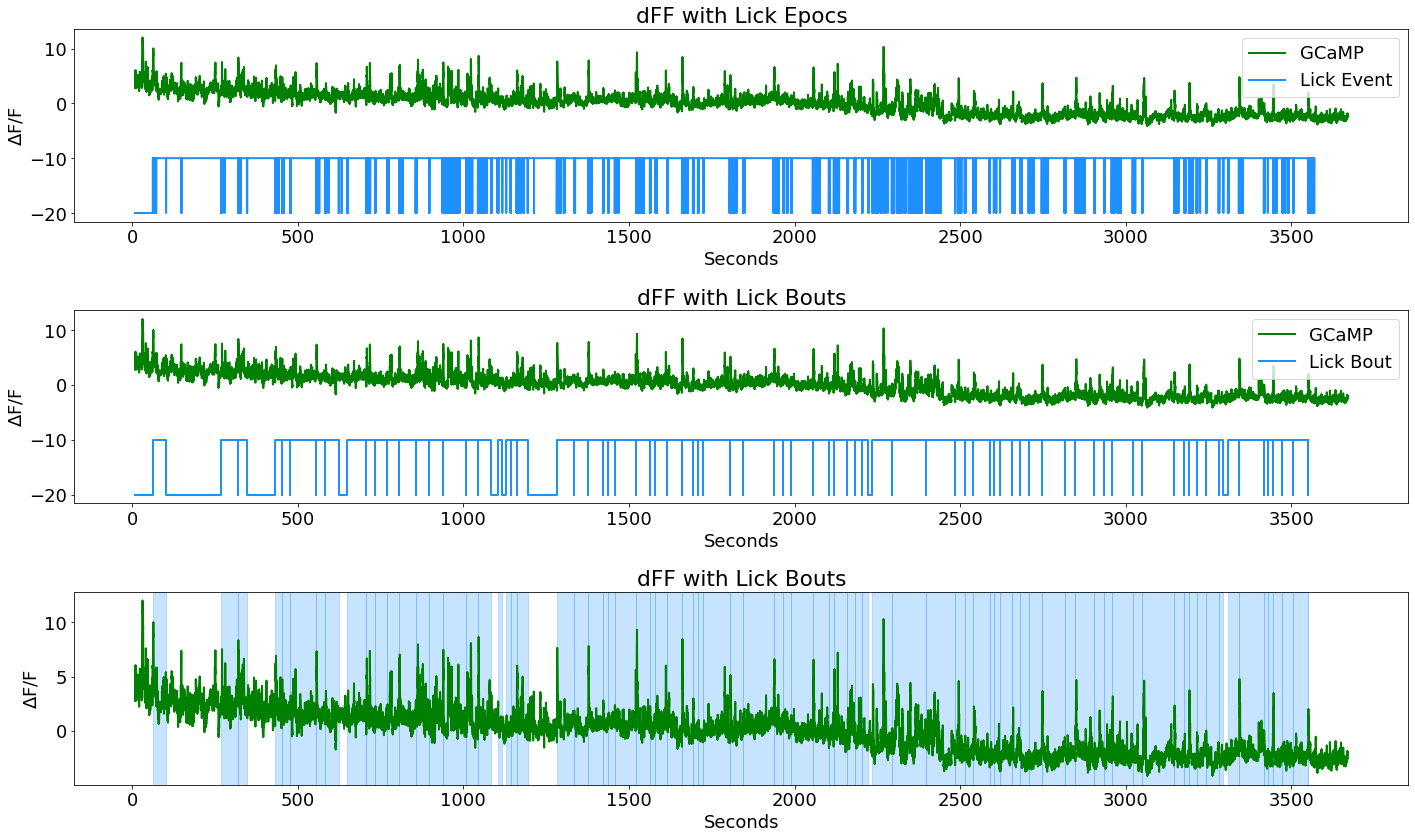

In [15]:
ax4 = fig3.add_subplot(313)
p1, = ax4.plot(time, dFF,linewidth=2, color='green', label='GCaMP')
for on, off in zip(data.epocs[LICK_EVENT].onset, data.epocs[LICK_EVENT].offset):
    ax4.axvspan(on, off, alpha=0.25, color='dodgerblue')
ax4.set_ylabel(r'$\Delta$F/F')
ax4.set_xlabel('Seconds')
ax4.set_title('dFF with Lick Bouts')
fig3.tight_layout()
fig3

# Time Filter Around Lick Bout Epocs
Note that we are using dFF of the full time series, not peri-event dFF where f0 is taken from a pre-event basaeline period.

In [16]:
PRE_TIME = 5 # five seconds before event onset
POST_TIME = 10 # ten seconds after
fs = data.streams[GCAMP].fs/N #recall we downsampled by N = 10 earlier

# time span for peri-event filtering, PRE and POST, in samples
TRANGE = [-PRE_TIME*np.floor(fs), POST_TIME*np.floor(fs)]

dFF_snips = []
array_ind = []
pre_stim = []
post_stim = []

for on in data.epocs[LICK_EVENT].onset:
    # If the bout cannot include pre-time seconds before event, make zero
    if on < PRE_TIME:
        dFF_snips.append(np.zeros(TRANGE[1]-TRANGE[0]))
    else: 
        # find first time index after bout onset
        array_ind.append(np.where(time > on)[0][0])
        # find index corresponding to pre and post stim durations
        pre_stim.append(array_ind[-1] + TRANGE[0])
        post_stim.append(array_ind[-1] + TRANGE[1])
        dFF_snips.append(dFF[int(pre_stim[-1]):int(post_stim[-1])])
        
# Make all snippets the same size based on min snippet length
min1 = np.min([np.size(x) for x in dFF_snips])
dFF_snips = [x[1:min1] for x in dFF_snips]

mean_dFF_snips = np.mean(dFF_snips, axis=0)
std_dFF_snips = np.std(mean_dFF_snips, axis=0)

peri_time = np.linspace(1, len(mean_dFF_snips), len(mean_dFF_snips))/fs - PRE_TIME

# Make a Peri-Event Stimulus Plot and Heat Map

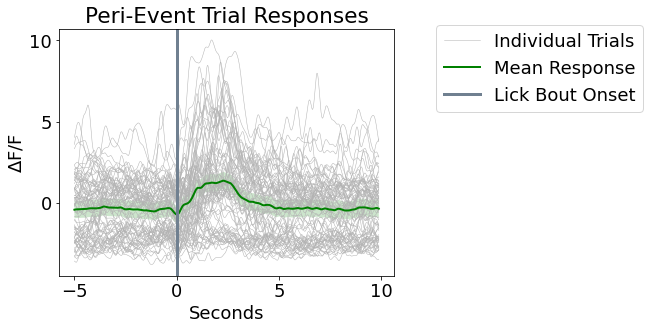

In [17]:
fig4 = plt.figure(figsize=(6,10))
ax5 = fig4.add_subplot(211)

for snip in dFF_snips:
    p1, = ax5.plot(peri_time, snip, linewidth=.5, color=[.7, .7, .7], label='Individual Trials')
p2, = ax5.plot(peri_time, mean_dFF_snips, linewidth=2, color='green', label='Mean Response')

# Plotting standard error bands
p3 = ax5.fill_between(peri_time, mean_dFF_snips+std_dFF_snips, 
                      mean_dFF_snips-std_dFF_snips, facecolor='green', alpha=0.2)
p4 = ax5.axvline(x=0, linewidth=3, color='slategray', label='Lick Bout Onset')

ax5.axis('tight')
ax5.set_xlabel('Seconds')
ax5.set_ylabel(r'$\Delta$F/F')
ax5.set_title('Peri-Event Trial Responses')
ax5.legend(handles=[p1, p2, p4], bbox_to_anchor=(1.1, 1.05));

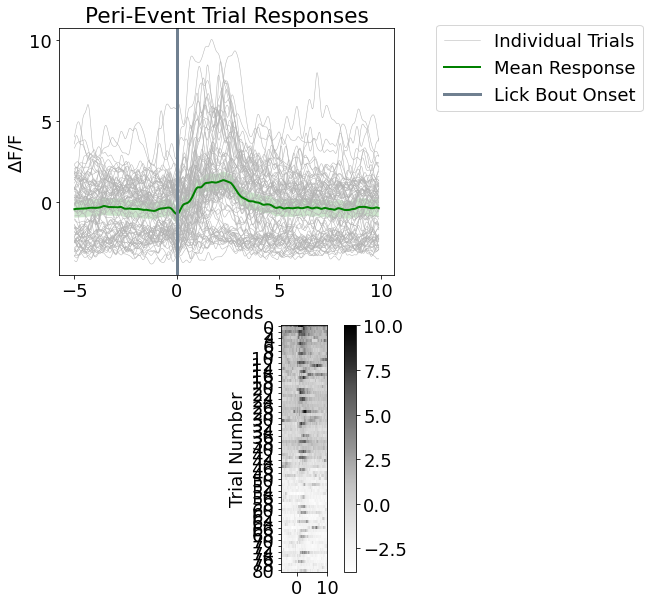

In [18]:
ax6 = fig4.add_subplot(212)
cs = ax6.imshow(dFF_snips, cmap=plt.cm.Greys,
                interpolation='none', extent=[-PRE_TIME,POST_TIME,len(dFF_snips),0],)
ax6.set_ylabel('Trial Number')
ax6.set_yticks(np.arange(.5, len(dFF_snips), 2))
ax6.set_yticklabels(np.arange(0, len(dFF_snips), 2))
fig4.colorbar(cs)
fig4